<a href="https://colab.research.google.com/github/educbd/ML_/blob/main/Graded_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DAB200 -- Graded Lab 3

In this lab, you will gain some experience in dealing with missing data and further practice converting non-numeric features in a dataset to numeric.

**Target**: to predict `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1-3 | veh14_missing.csv |
| 4-5 | veh15_missing.csv |
| 6-8 | veh16_missing.csv |
| 9-11 | veh17_missing.csv |
| 12-14 | veh18_missing.csv |
| 15-17 | veh19_missing.csv |

**Important Notes:**
- Use [Chapter 7](https://mlbook.explained.ai/bulldozer-intro.html) of the textbook as a **guide**:
     - you only need to use **random forest** models;
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit Anaconda, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
- Don't make assumptions!


### Part 0

Please provide the following information:
 - Group Number:
  - No. 14
 - Group Members:
  - Noushin Asadsamani (0829532)
  - Eduardo Chavez Barrientos (0828349)
  - Prasanna Kumar Loganathan (0827541)

     

##### Setting up the notebook:

In [66]:
!pip install rfpimp
!pip install category_encoders

In [67]:
import numpy as np
import pandas as pd
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import category_encoders as ce
from rfpimp import *

In [68]:
# Defining a function to SNIFF the data:
def sniff_mod(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = df.iloc[0]
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

In [69]:
# Defining a function to EVALUATE the model:
def evaluate(X, y, n_estimators=150):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB score is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [70]:
# Defining a function to show FEATURE IMPORTANCE:
def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

### Part 1 - Create and evaluate an initial model

In this part you should:
 - use Section 7.3 of the textbook as a guide, except:
     - use all of the data; and
     - use 150 decision trees in your random forest models
 - read in the data
 - isolate all numeric features from original data set
 - fill in any missing values with 0
 - create and evaluate a baseline model

#### Code (10 marks)

In [71]:
# Read in the data:
df_raw = pd.read_csv('https://github.com/educbd/ML_/blob/main/veh18_missing.csv?raw=true')
sniff_mod(df_raw)

,sample,data type,percent missing,No. unique,unique values
# Cyl,6,int64,0.000000,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,6,int64,0.000000,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,2,int64,0.000000,2,"[2, 1]"
Exhaust Valves Per Cyl,2,int64,0.000000,2,"[2, 1]"
Eng Displ,NaN,float64,29.302326,41,"[nan, 6.2, 2.0, 4.4, 3.0, 5.2, 1.6, 2.7, 4.0, ..."
Comb Unadj FE - Conventional Fuel,26.21,float64,0.000000,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,15.0,float64,2.945736,4,"[15.0, 10.0, nan, 85.0]"
Fuel Metering Sys Desc,Multipoint/sequential fuel injection,object,0.000000,5,"[Multipoint/sequential fuel injection, Spark I..."
Air Aspiration Method Desc,Naturally Aspirated,object,0.000000,4,"[Naturally Aspirated, Turbocharged, Supercharg..."
Trans Desc,XXXXX,object,0.000000,8,"[XXXXX, Semi-Automatic, Automated Manual, Manu..."


In [72]:
# Isolate all numeric features from original dataset:
df = df_raw.copy()
df = df.select_dtypes(include='number')

In [73]:
# Fill in any missing values with 0:
df = df.replace(np.nan, 0)

In [74]:
# Checking whether any value is null after filling with zero
df.isnull().sum()

Eng Displ                            0
# Cyl                                0
Comb Unadj FE - Conventional Fuel    0
# Gears                              0
Max Ethanol % - Gasoline             0
Intake Valves Per Cyl                0
Exhaust Valves Per Cyl               0
dtype: int64

In [75]:
# Features X1 and target y1
X1 = df.drop('Comb Unadj FE - Conventional Fuel', axis=1)
y1 = df['Comb Unadj FE - Conventional Fuel']

In [76]:
# Create and evaluate a baseline model:
oob_scores1 = []
r2_1 = []

for i in range(10):
    model_1 = RandomForestRegressor(n_estimators = 150, n_jobs = -1, oob_score = True)
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2)
    model_1.fit(X1_train, y1_train)
    oob_scores1.append(model_1.oob_score_)
    r2_1.append(model_1.score(X1_train, y1_train))

avg_oob_scores_1 = sum(oob_scores1) / len(oob_scores1)
avg_r2_1 = sum(r2_1) / len(r2_1)
print(f"Average of oob_score over 10 runs for model_1 is: {avg_oob_scores_1:.4f}")
print(f"Average of R^2 over 10 runs for model_1 is: {avg_r2_1:.4f}")

Average of oob_score over 10 runs for model_1 is: 0.6730
Average of R^2 over 10 runs for model_1 is: 0.7505


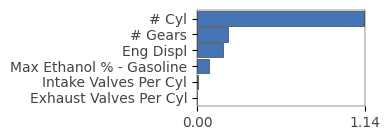

In [77]:
# Ploting the feature importance:
showimp(model_1, X1, y1)

### Part 2 - Normalize missing values

In this part you should:
 - use Section 7.4 of the textbook as a guide
 - convert **all** representations of missing data to a **single** representation

#### Code (15 marks)

In [78]:
# Taking a look to the new data
sniff_mod(df_raw)

,sample,data type,percent missing,No. unique,unique values
# Cyl,6,int64,0.000000,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,6,int64,0.000000,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,2,int64,0.000000,2,"[2, 1]"
Exhaust Valves Per Cyl,2,int64,0.000000,2,"[2, 1]"
Eng Displ,NaN,float64,29.302326,41,"[nan, 6.2, 2.0, 4.4, 3.0, 5.2, 1.6, 2.7, 4.0, ..."
Comb Unadj FE - Conventional Fuel,26.21,float64,0.000000,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,15.0,float64,2.945736,4,"[15.0, 10.0, nan, 85.0]"
Fuel Metering Sys Desc,Multipoint/sequential fuel injection,object,0.000000,5,"[Multipoint/sequential fuel injection, Spark I..."
Air Aspiration Method Desc,Naturally Aspirated,object,0.000000,4,"[Naturally Aspirated, Turbocharged, Supercharg..."
Trans Desc,XXXXX,object,0.000000,8,"[XXXXX, Semi-Automatic, Automated Manual, Manu..."


In [79]:
# Checking columns for unique values
for col in df_raw:
    print(f'{col} : {df_raw[col].unique()}')

Eng Displ : [nan 6.2 2.  4.4 3.  5.2 1.6 2.7 4.  3.6 1.4 3.5 5.5 1.5 2.5 5.3 1.  5.7
 2.4 2.2 1.8 6.5 5.  3.8 5.6 2.8 6.4 2.3 3.3 6.  1.2 4.3 2.9 4.7 8.  6.3
 3.9 3.2 3.7 6.8 6.6]
# Cyl : [ 6  8  4 12  3 10  5 16]
Comb Unadj FE - Conventional Fuel : [26.21   21.8108 35.6914 ... 24.8658 33.1287 30.057 ]
# Gears : [ 6  8  7 10  9  1  5  4]
Max Ethanol % - Gasoline : [15. 10. nan 85.]
Intake Valves Per Cyl : [2 1]
Exhaust Valves Per Cyl : [2 1]
Fuel Metering Sys Desc : ['Multipoint/sequential fuel injection' 'Spark Ignition Direct Injection'
 'unknown' 'Common Rail Direct Diesel Injection'
 'Spark Ignition direct & ported injection']
Air Aspiration Method Desc : ['Naturally Aspirated' 'Turbocharged' 'Supercharged'
 'Turbocharged+Supercharged']
Trans Desc : ['XXXXX' 'Semi-Automatic' 'Automated Manual' 'Manual' 'Automatic'
 'Selectable Continuously Variable (e.g. CVT with paddles)'
 'Automated Manual- Selectable (e.g. Automated Manual with paddles)'
 'Continuously Variable']
Cyl Deact? : ['

#### Normalize the Representation of Missing Values

It will be much easier to handle if we convert all the different ways this data has to signal missing data down to a single representation: `np.nan`. To do this we will use the following function which:
- converts all strings (text) to lower case;
- fill actual missing data with `np.nan`
- convert all the other representations ('unknown', 'xxxxx', and '   ') to `np.nan`.

In [80]:
from pandas.api.types import is_string_dtype, is_object_dtype

def df_raw_normalize_strings(df_raw):
    for col in df_raw.columns:
        if is_string_dtype(df_raw[col]) or is_object_dtype(df_raw[col]):
            df_raw[col] = df_raw[col].str.lower()
            df_raw[col] = df_raw[col].fillna(np.nan)
            df_raw[col] = df_raw[col].replace('unknown', np.nan)
            df_raw[col] = df_raw[col].replace('xxxxx', np.nan)
            df_raw[col] = df_raw[col].replace('   ', np.nan)

df_raw_normalize_strings(df_raw)
sniff_mod(df_raw)

,sample,data type,percent missing,No. unique,unique values
# Cyl,6,int64,0.000000,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,6,int64,0.000000,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,2,int64,0.000000,2,"[2, 1]"
Exhaust Valves Per Cyl,2,int64,0.000000,2,"[2, 1]"
Eng Displ,NaN,float64,29.302326,41,"[nan, 6.2, 2.0, 4.4, 3.0, 5.2, 1.6, 2.7, 4.0, ..."
Comb Unadj FE - Conventional Fuel,26.21,float64,0.000000,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,15.0,float64,2.945736,4,"[15.0, 10.0, nan, 85.0]"
Fuel Metering Sys Desc,multipoint/sequential fuel injection,object,29.069767,5,"[multipoint/sequential fuel injection, spark i..."
Air Aspiration Method Desc,naturally aspirated,object,0.000000,4,"[naturally aspirated, turbocharged, supercharg..."
Trans Desc,NaN,object,41.162791,8,"[nan, semi-automatic, automated manual, manual..."


#### Question (5 marks)

Note here all the different ways missing data was represented in the data.   

**Enter your answer here:**

### Part 3 - Categorical features

In this part you should:
 - use Section 7.5.1 as a guide
 - only use ordinal encoding
 - convert **all** non-numeric features to numeric
 - handle any missing values

#### Code (25 marks)

In [81]:
# Check the dataset for categorical columns
df_obj = df_raw.select_dtypes(include=[object])
df_obj.head()

,Fuel Metering Sys Desc,Air Aspiration Method Desc,Trans Desc,Cyl Deact?,Var Valve Lift?
0,multipoint/sequential fuel injection,naturally aspirated,NaN,n,n
1,spark ignition direct injection,naturally aspirated,NaN,NaN,n
2,NaN,turbocharged,semi-automatic,n,y
3,NaN,turbocharged,automated manual,n,n
4,multipoint/sequential fuel injection,naturally aspirated,NaN,n,n


In [82]:
# Check unique values for categorical columns
for col in df_obj:
    print(f'{col} : {df_obj[col].unique()}')

Fuel Metering Sys Desc : ['multipoint/sequential fuel injection' 'spark ignition direct injection'
 nan 'common rail direct diesel injection'
 'spark ignition direct & ported injection']
Air Aspiration Method Desc : ['naturally aspirated' 'turbocharged' 'supercharged'
 'turbocharged+supercharged']
Trans Desc : [nan 'semi-automatic' 'automated manual' 'manual' 'automatic'
 'selectable continuously variable (e.g. cvt with paddles)'
 'automated manual- selectable (e.g. automated manual with paddles)'
 'continuously variable']
Cyl Deact? : ['n' nan 'y']
Var Valve Lift? : ['n' 'y']


In [83]:
from pandas.api.types import is_categorical_dtype, is_string_dtype

def df_string_to_cat(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [84]:
df_string_to_cat(df_obj)
df_cat_to_catcode(df_obj)

In [85]:
sniff_mod(df_obj)

,sample,data type,percent missing,No. unique,unique values
Fuel Metering Sys Desc,2,int8,0.0,5,"[2, 4, 0, 1, 3]"
Air Aspiration Method Desc,1,int8,0.0,4,"[1, 3, 2, 4]"
Trans Desc,0,int8,0.0,8,"[0, 7, 1, 5, 3, 6, 2, 4]"
Cyl Deact?,1,int8,0.0,3,"[1, 0, 2]"
Var Valve Lift?,1,int8,0.0,2,"[1, 2]"


### Part 4 - Numeric features

In this part you should:
 - use Section 7.5.2 as a guide
 - handle any missing values

#### Code (30 marks)

In [94]:
df_num = df_raw.select_dtypes(include='number')
df_num.head()

,Eng Displ,# Cyl,Comb Unadj FE - Conventional Fuel,# Gears,Max Ethanol % - Gasoline,Intake Valves Per Cyl,Exhaust Valves Per Cyl
0,NaN,6,26.2100,6,15.0,2,2
1,6.2,8,21.8108,8,10.0,1,1
2,2.0,4,35.6914,8,10.0,2,2
3,2.0,4,36.7994,7,10.0,2,2
4,NaN,8,18.9885,6,15.0,2,2


In [95]:
df_num.isnull().sum()

Eng Displ                            378
# Cyl                                  0
Comb Unadj FE - Conventional Fuel      0
# Gears                                0
Max Ethanol % - Gasoline              38
Intake Valves Per Cyl                  0
Exhaust Valves Per Cyl                 0
dtype: int64

In [96]:
# Filling the missing values with median
def fix_missing_num(df, colname):
    df[colname].fillna(df[colname].median(), inplace=True)

In [97]:
fix_missing_num(df_num, 'Eng Displ')
fix_missing_num(df_num, 'Max Ethanol % - Gasoline')

In [98]:
sniff_mod(df_num)

,sample,data type,percent missing,No. unique,unique values
# Cyl,6.00,int64,0.0,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,6.00,int64,0.0,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,2.00,int64,0.0,2,"[2, 1]"
Exhaust Valves Per Cyl,2.00,int64,0.0,2,"[2, 1]"
Eng Displ,3.00,float64,0.0,40,"[3.0, 6.2, 2.0, 4.4, 5.2, 1.6, 2.7, 4.0, 3.6, ..."
Comb Unadj FE - Conventional Fuel,26.21,float64,0.0,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,15.00,float64,0.0,3,"[15.0, 10.0, 85.0]"


### Part 5 - Create and evaluate a final model

In this part you should:
 - create and evaluate a model using all the features after processing them in Parts 2, 3, and 4 above

#### Code (10 marks)

In [99]:
final_df = pd.concat([df_obj,df_num], axis=1)
final_df.head()

,Fuel Metering Sys Desc,Air Aspiration Method Desc,Trans Desc,Cyl Deact?,Var Valve Lift?,Eng Displ,# Cyl,Comb Unadj FE - Conventional Fuel,# Gears,Max Ethanol % - Gasoline,Intake Valves Per Cyl,Exhaust Valves Per Cyl
0,2,1,0,1,1,3.0,6,26.2100,6,15.0,2,2
1,4,1,0,0,1,6.2,8,21.8108,8,10.0,1,1
2,0,3,7,1,2,2.0,4,35.6914,8,10.0,2,2
3,0,3,1,1,1,2.0,4,36.7994,7,10.0,2,2
4,2,1,0,1,1,3.0,8,18.9885,6,15.0,2,2


In [100]:
sniff_mod(final_df)

,sample,data type,percent missing,No. unique,unique values
Fuel Metering Sys Desc,2.00,int8,0.0,5,"[2, 4, 0, 1, 3]"
Air Aspiration Method Desc,1.00,int8,0.0,4,"[1, 3, 2, 4]"
Trans Desc,0.00,int8,0.0,8,"[0, 7, 1, 5, 3, 6, 2, 4]"
Cyl Deact?,1.00,int8,0.0,3,"[1, 0, 2]"
Var Valve Lift?,1.00,int8,0.0,2,"[1, 2]"
# Cyl,6.00,int64,0.0,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,6.00,int64,0.0,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,2.00,int64,0.0,2,"[2, 1]"
Exhaust Valves Per Cyl,2.00,int64,0.0,2,"[2, 1]"
Eng Displ,3.00,float64,0.0,40,"[3.0, 6.2, 2.0, 4.4, 5.2, 1.6, 2.7, 4.0, 3.6, ..."


In [101]:
# Features X2 and target y2
X2 = final_df.drop('Comb Unadj FE - Conventional Fuel', axis=1)
y2 = final_df['Comb Unadj FE - Conventional Fuel']

In [102]:
# Create and evaluate a final model:
oob_scores2 = []
r2_2 = []

for i in range(10):
    model_2 = RandomForestRegressor(n_estimators = 150, n_jobs = -1, oob_score = True)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2)
    model_2.fit(X2_train, y2_train)
    oob_scores2.append(model_2.oob_score_)
    r2_2.append(model_2.score(X2_train, y2_train))

avg_oob_scores_2 = sum(oob_scores2) / len(oob_scores2)
avg_r2_2 = sum(r2_2) / len(r2_2)
print(f"Average of oob_score over 10 runs for model_2 is: {avg_oob_scores_2:.4f}")
print(f"Average of R^2 over 10 runs for model_2 is: {avg_r2_2:.4f}")

Average of oob_score over 10 runs for model_2 is: 0.7678
Average of R^2 over 10 runs for model_2 is: 0.9400


#### Questions (5 marks)

Provide answers to the following:
 1. calculate the percent difference between the results of Part 1 and Part 5 (make sure you are using the correct formula for percent difference)
 2. based on the percent difference, state whether or not the results of Part 5 are an improvement over the results of Part 1

**Enter your answers here:**